# Dataset Cleaning
This notebook pollutes a train set by randomly flipping labels, then prioritizes train instances to check to fix them.

In [4]:
import os
import sys
sys.path.insert(0, os.getcwd() + '/../')  # for scripts
sys.path.insert(0, os.getcwd() + '/../../')  # for util

from scripts.cleaning import noise_detection
data_dir = '../../data'

train instances: 26215
test instances: 6554
num noisy labels: 10486

Before noise:
model (CatBoostClassifier)
test set acc: 0.941562
missed test instances (383)
test log loss: 0.18010

After noise:
model (CatBoostClassifier)
test set acc: 0.883583
missed test instances (763)
test log loss: 0.55343


100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


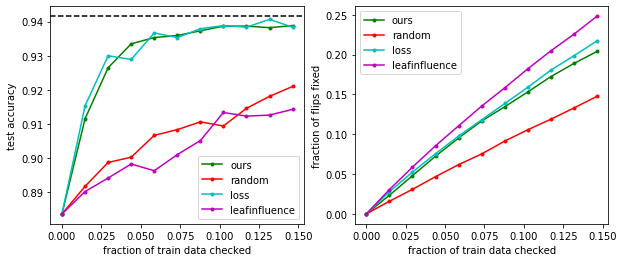

In [5]:
noise_detection(model_type='cb', encoding='tree_output', dataset='amazon', n_estimators=100, random_state=1, inf_k=0,
                data_dir=data_dir, svm_loss=False)

train instances: 32561
test instances: 16281
num noisy labels: 13024

Before noise:
model (CatBoostClassifier)
test set acc: 0.868313
missed test instances (2144)
test log loss: 0.28596

After noise:
model (CatBoostClassifier)
test set acc: 0.806277
missed test instances (3154)
test log loss: 0.59129


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


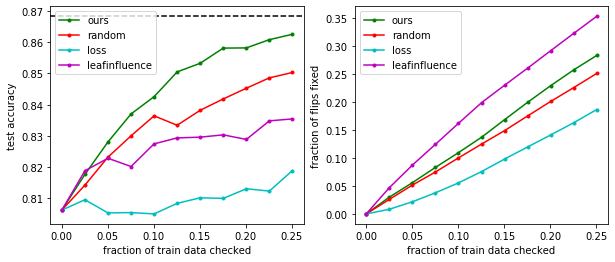

In [6]:
noise_detection(model_type='cb', encoding='tree_output', dataset='adult', n_estimators=100, random_state=1, inf_k=0,
                data_dir=data_dir, svm_loss=False)

train instances: 3019
test instances: 755
num noisy labels: 800

Before noise:
model (CatBoostClassifier)
test set acc: 0.941722
missed test instances (44)
test log loss: 0.17608

After noise:
model (CatBoostClassifier)
test set acc: 0.890066
missed test instances (83)
test log loss: 0.40231


100%|██████████| 10/10 [00:13<00:00,  1.28s/it]


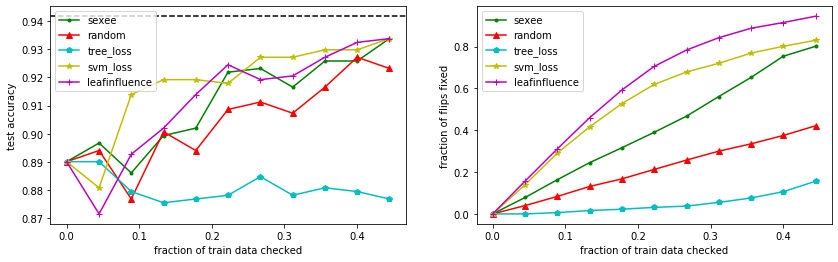

In [3]:
noise_detection(model_type='cb', encoding='tree_output', dataset='medifor2', n_estimators=100, random_state=2, inf_k=0,
                data_dir=data_dir, svm_loss=True)